In [1]:
import os
import PIL
import shutil
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, save_model

2025-07-19 17:13:50.415770: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-19 17:13:50.427379: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752925430.440311   45047 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752925430.443361   45047 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752925430.452091   45047 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

In [4]:
data_dir = tf.keras.utils.get_file("flower_photos", origin=dataset_url, untar=True)

In [5]:
type(data_dir)

str

In [6]:
data_dir = pathlib.Path(data_dir)

In [7]:
image_count = len(list(data_dir.glob("*/*.jpg")))

In [8]:
image_count

0

In [9]:
data_dir = data_dir / "flower_photos"
image_count = len(list(data_dir.glob("*/*.jpg")))
print(f"New image count: {image_count}")

New image count: 3670


In [10]:
image_count

3670

In [11]:
batch_size = 32
img_height = 180
img_width = 180

In [12]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2025-07-19 17:14:00.969457: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [13]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [14]:
class_names = train_ds.class_names
print("Class Names:", class_names)

Class Names: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [15]:
train_ds = train_ds.cache().shuffle(1000)

val_ds = val_ds.cache()

In [16]:
num_classes = len(class_names)
num_classes

5

In [17]:
# # Modeling

# model = Sequential([
#     layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

#     layers.Conv2D(16, 3, padding="same", activation="relu"),
#     layers.MaxPooling2D(),

#     layers.Conv2D(32, 3, padding="same", activation="relu"),
#     layers.MaxPooling2D(),

#     layers.Conv2D(64, 3, padding="same", activation="relu"),
#     layers.MaxPooling2D(),

#     layers.Flatten(),

#     layers.Dense(128, activation='relu'),

#     layers.Dense(num_classes)
# ])



# from tensorflow.keras import layers, models, Sequential

model = Sequential([
    # Normalize pixel values
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # Data Augmentation block
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),

    # Conv block 1
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),  # helps prevent overfitting

    # Conv block 2
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Conv block 3
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Flatten and Dense
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Output layer
    layers.Dense(num_classes, activation='softmax')  # add softmax if using sparse_categorical_crossentropy
])


/home/petpooja-1154/.local/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [19]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 180, 180, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 90, 90, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,990,245 (15.22 MB)

 Trainable params: 3,989,765 (15.22 MB)

 Non-trainable params: 480 (1.88 KB)

None


In [20]:
epochs = 50

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/50


/home/petpooja-1154/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


92/92 ━━━━━━━━━━━━━━━━━━━━ 37s 373ms/step - accuracy: 0.3934 - loss: 1.8354 - val_accuracy: 0.2398 - val_loss: 3.7718
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 393ms/step - accuracy: 0.4969 - loss: 1.3408 - val_accuracy: 0.2398 - val_loss: 4.6000
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 393ms/step - accuracy: 0.5613 - loss: 1.1812 - val_accuracy: 0.2575 - val_loss: 2.8667
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 393ms/step - accuracy: 0.5654 - loss: 1.1143 - val_accuracy: 0.3134 - val_loss: 2.5572
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 394ms/step - accuracy: 0.5988 - loss: 1.0336 - val_accuracy: 0.3856 - val_loss: 1.8431
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 393ms/step - accuracy: 0.6082 - loss: 0.9967 - val_accuracy: 0.4646 - val_loss: 1.5111
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 436ms/step - accuracy: 0.6173 - loss: 0.9909 - val_accuracy: 0.5218 - val_loss: 1.3322
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 393ms/step - accuracy: 0.6269 - loss: 0.9685 - val_accuracy: 0.598

In [21]:
acc = history.history['accuracy']

val_acc = history.history['val_accuracy']

In [22]:
loss = history.history['loss']

val_loss = history.history['val_loss']

In [23]:
epoch_range = range(epochs)
epoch_range

range(0, 50)

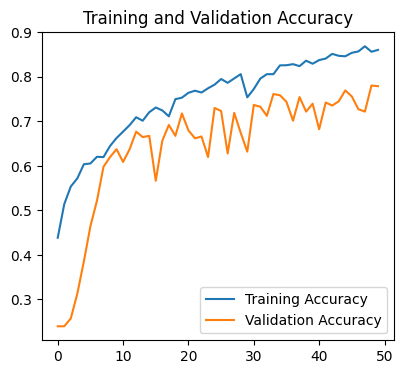

In [24]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epoch_range, acc, label="Training Accuracy")
plt.plot(epoch_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.show()

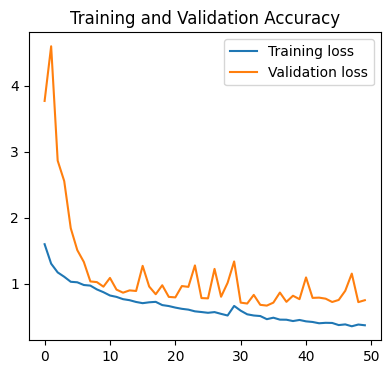

In [25]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epoch_range, loss, label="Training loss")
plt.plot(epoch_range, val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Accuracy")
plt.show()

In [26]:
save_model(model, "flower_model_trained.hdf5")

print("Model saved successfully.")

Model saved successfully.
